In [1]:
library(readr)
library(dplyr)
library(stringr)
library(lfe)
library(ggsci)
library(lubridate)
library(ggplot2)
library(doMC)
library(gridExtra)
library(ggpubr)
library(stargazer)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘lubridate’


The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [2]:
fp  <- '/pool001/mfzhao/'
df  <- read_rds(str_c(fp, '/PROCESSED_DATA/panel_pre_xgr.RDS'))
sci <- read_csv(str_c(fp, 'PROCESSED_DATA/processed_sci.csv'))

Parsed with column specification:
cols(
  user_county = col_character(),
  fr_county = col_character(),
  scaled_sci = col_double(),
  n = col_double()
)



In [3]:
df %>%
    mutate(as_newcases  = asinh(newcases),
           as_newdeaths = asinh(newdeaths),
           as_stnewcases  = asinh(stnewcases),
           as_stnewdeaths = asinh(stnewdeaths)) %>%
    select(key,
           date, 
           cluster,
           n,
           log_mcbgv,
           log_pnchd,
           log_pgt1hafh, 
           log_ppthlt75,
           log_pgt2kmt,
           matches('^[pt][rm][ca][px][01][0-9]$'),
           matches('^p[123]...$'),
           matches('stalter_p[123]...$'),
           matches('as_(st)?new')) -> df

In [4]:
ldvs <- c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd')

In [5]:
get_coefs <- function(df, dv, vars, ivmod = F, ...) {
    lhs <- str_c(dv, ' ~ ')
    rhs <- str_c(vars, '| key + date | ')

    if(ivmod == T) {
        alter_weather <- str_c(cns[str_detect(cns, '^stalter_[pt][rm][ca][px][01][0-9]$')], collapse = ' + ')
        iv <- ifelse(str_detect(dv, 'log'), str_replace(dv, 'log', 'log_stalter'), str_c('alter_', dv))
        ivf <- str_c('(', iv, ' ~ ', alter_weather, ') | cluster')
        rhs <- str_c(rhs, ivf)
    } else {
        rhs <- str_c(rhs, '0 | cluster')
    }
    form <- as.formula(str_c(lhs, rhs))
    model <- felm(form, df, weights = df$n, ...)
    
    as.data.frame(summary(model)$coef) %>%
        mutate(var   = rownames(.),
               dv    = dv,
               model = 'ap',
               model = ifelse(ivmod, str_c(model, ' + iv'), model)) %>%
        filter(!str_detect(var, '[pPtT][rRmM][cCaA][pPxX]')) %>%
        select(7, 6, 5, 1, 2, 3, 4) -> out
    
    colnames(out) <- c('model', 'dv', 'var', 'estimate', 'se', 't', 'p-val')
    return(out)
}

In [18]:
ctrls <- '+ prcp01 + prcp02 + prcp03 + prcp04 + prcp05 + prcp06 + prcp07 + prcp08 + prcp09 + prcp10 + 
            tmax02 + tmax03 + tmax04 + tmax05 + tmax06 + tmax07 + tmax08 + tmax09 + tmax10 + 
            as_newcases + as_newdeaths + as_stnewcases + as_stnewdeaths'
form  <- str_c(' p1sdp + p2shp + p3rop + stalter_p1sdp + stalter_p2shp + stalter_p3rop ', ctrls)

In [30]:
foreach(dv = ldvs, .combine = rbind) %do%
    get_coefs(df, dv, form, F) -> coefs

In [22]:
weightedAlters <- function(df, wm, ...) {
    df %>% 
        select(date, key, ...) %>%
        spread(key = key, value = ...) %>%
        ungroup() %>%
        select(-date) %>%
        as.matrix() -> txn_data
    
    df %>%
        ungroup() %>%
        select(date) %>%
        distinct() %>%
        arrange(date) -> dates
    
    outMatrix <- tcrossprod(txn_data, wm)
    colnames(outMatrix) <- colnames(txn_data)
    
    data.frame(dates, outMatrix) %>%
        gather(key = 'key', value = 'value', -date) %>%
        arrange(date, key) %>%
        select(-date, -key) -> out_df
    return(out_df$value)
}

In [23]:
sci %>%
    mutate(user_state = str_sub(user_county, 1, 2),
           fr_state   = str_sub(fr_county, 1, 2)) %>%
    filter(user_state != fr_state) %>%
    mutate(w = scaled_sci * n) %>%
    select(user_county, fr_county, w) -> sci

In [28]:
sim <- function(i) {
    sci %>%
        mutate(w = sample(w)) %>%
        group_by(user_county) %>%
        mutate(w = w/sum(w)) %>%
        ungroup() %>%
        spread(key = fr_county, value = w) %>%
        replace(is.na(.), 0) %>%
        select(-user_county) %>%
        as.matrix() -> WM
    
    df %>%
        ungroup() %>%
        mutate(stalter_p1sdp = weightedAlters(., WM, 'p1sdp'),
               stalter_p2shp = weightedAlters(., WM, 'p2shp'),
               stalter_p3rop = weightedAlters(., WM, 'p3rop')) -> df_fri
    
    foreach(dv = ldvs, .combine = rbind) %do%
        get_coefs(df_fri, dv, form, F) %>% 
        mutate(iter = i) -> coefs
    
    return(coefs)
}

In [29]:
registerDoMC(28)
fri_results <- foreach(i = 1:500, .combine = rbind) %dopar% sim(i)

In [39]:
coefs

model,dv,var,estimate,se,t,p-val
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ap,log_mcbgv,p1sdp,-0.0116289121,0.0065433407,-1.7772133,8.161610e-02
ap,log_mcbgv,p2shp,-0.0281689853,0.0048122968,-5.8535428,3.693428e-07
ap,log_mcbgv,p3rop,0.0161246002,0.0046262546,3.4854546,1.032217e-03
ap,log_mcbgv,stalter_p1sdp,-0.0663158775,0.0218402817,-3.0364021,3.796651e-03
ap,log_mcbgv,stalter_p2shp,-0.1100061807,0.0418076522,-2.6312451,1.128164e-02
ap,log_mcbgv,stalter_p3rop,0.1161065677,0.0262904121,4.4163084,5.381993e-05
ap,log_mcbgv,as_newcases,-0.0103926723,0.0010936526,-9.5027182,8.692316e-13
ap,log_mcbgv,as_newdeaths,-0.0074284524,0.0018069735,-4.1109913,1.464228e-04
ap,log_mcbgv,as_stnewcases,0.0014689292,0.0006854812,2.1429169,3.701085e-02


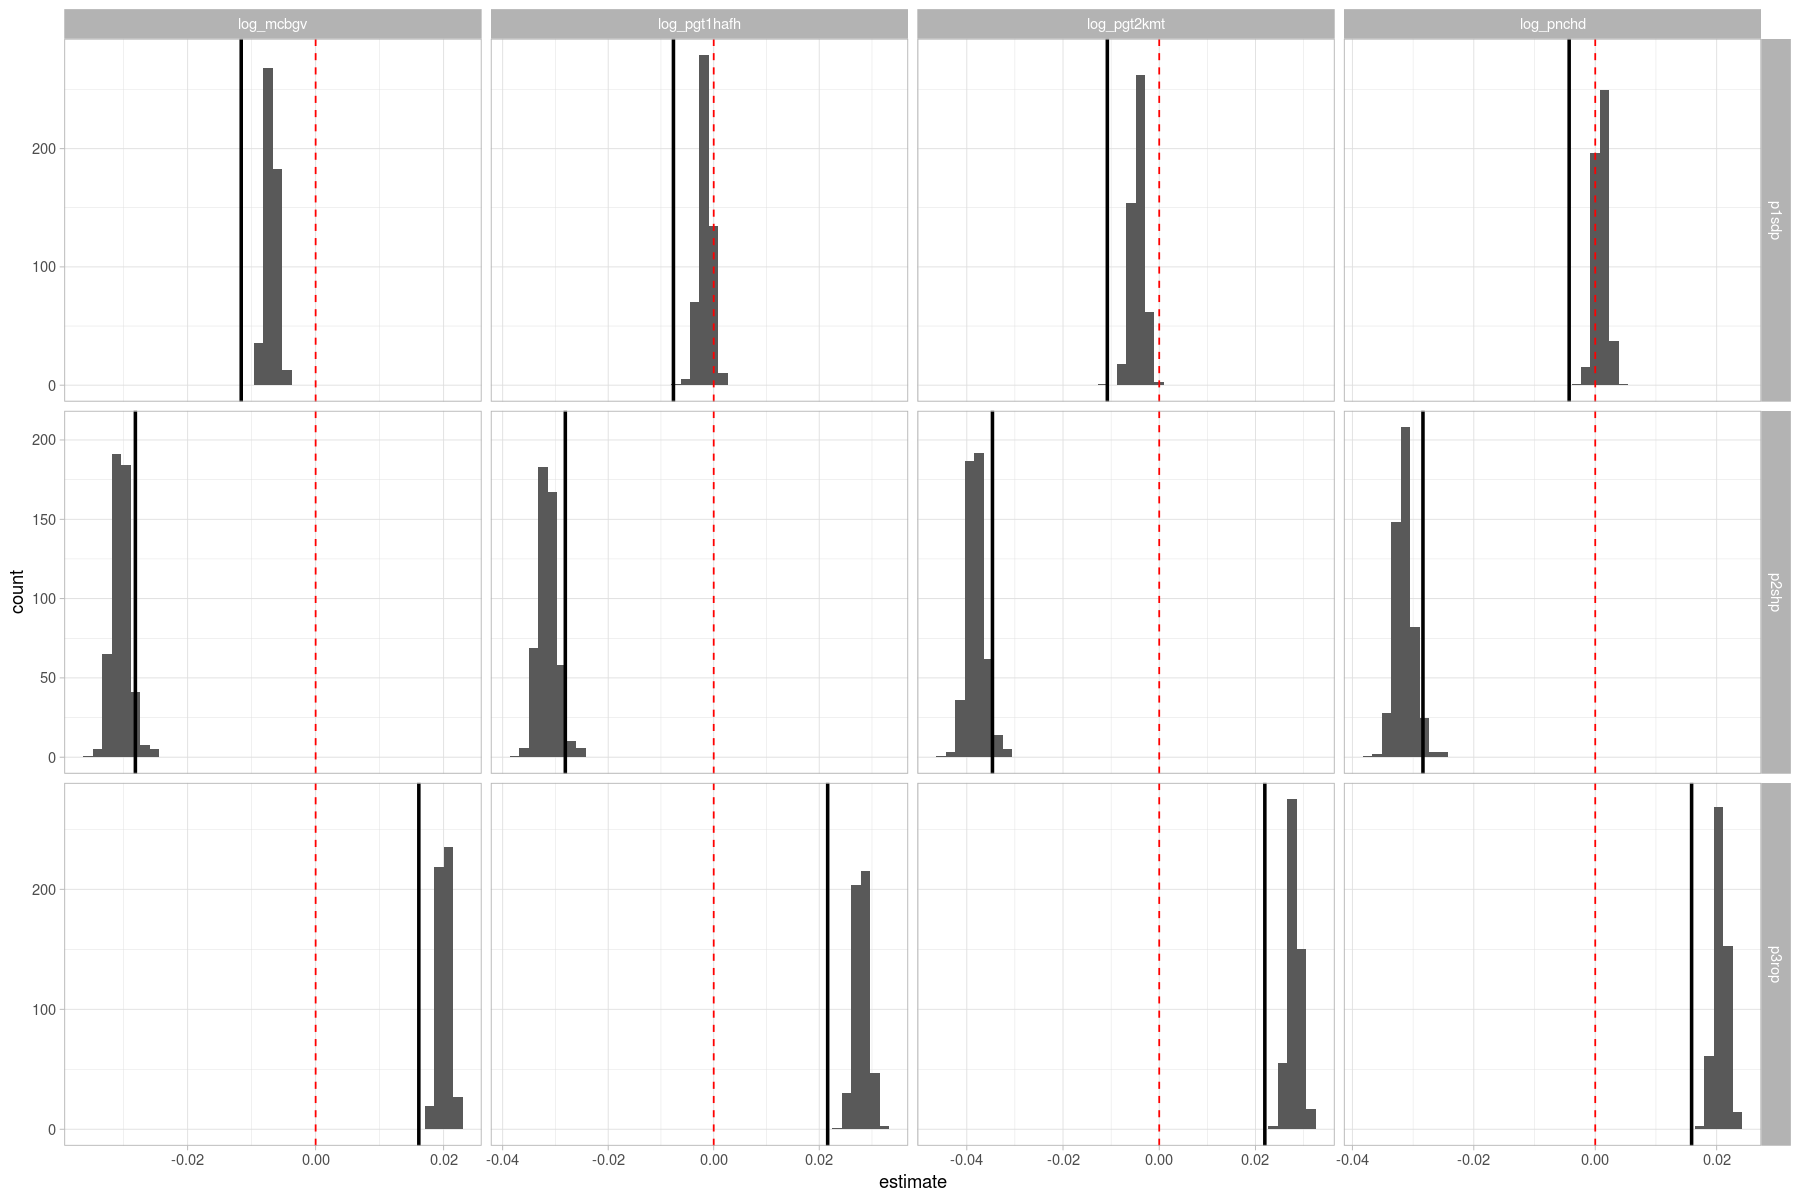

In [52]:
coefs %>%
    filter(!str_detect(var, 'new')) %>%
    filter(!str_detect(var, 'stalter')) -> ego_coefs

fri_results %>%
    filter(!str_detect(var, 'new')) %>%
    filter(!str_detect(var, 'stalter')) %>%
    ggplot(aes(x = estimate)) +
    geom_histogram(bins = 40) +
    geom_vline(aes(xintercept = 0), size = 0.5, color = 'red', linetype = 2) +
    geom_vline(aes(xintercept = estimate), data = ego_coefs, size = 1) + 
    facet_grid(var ~ dv, scales = 'free') +
    theme_light()

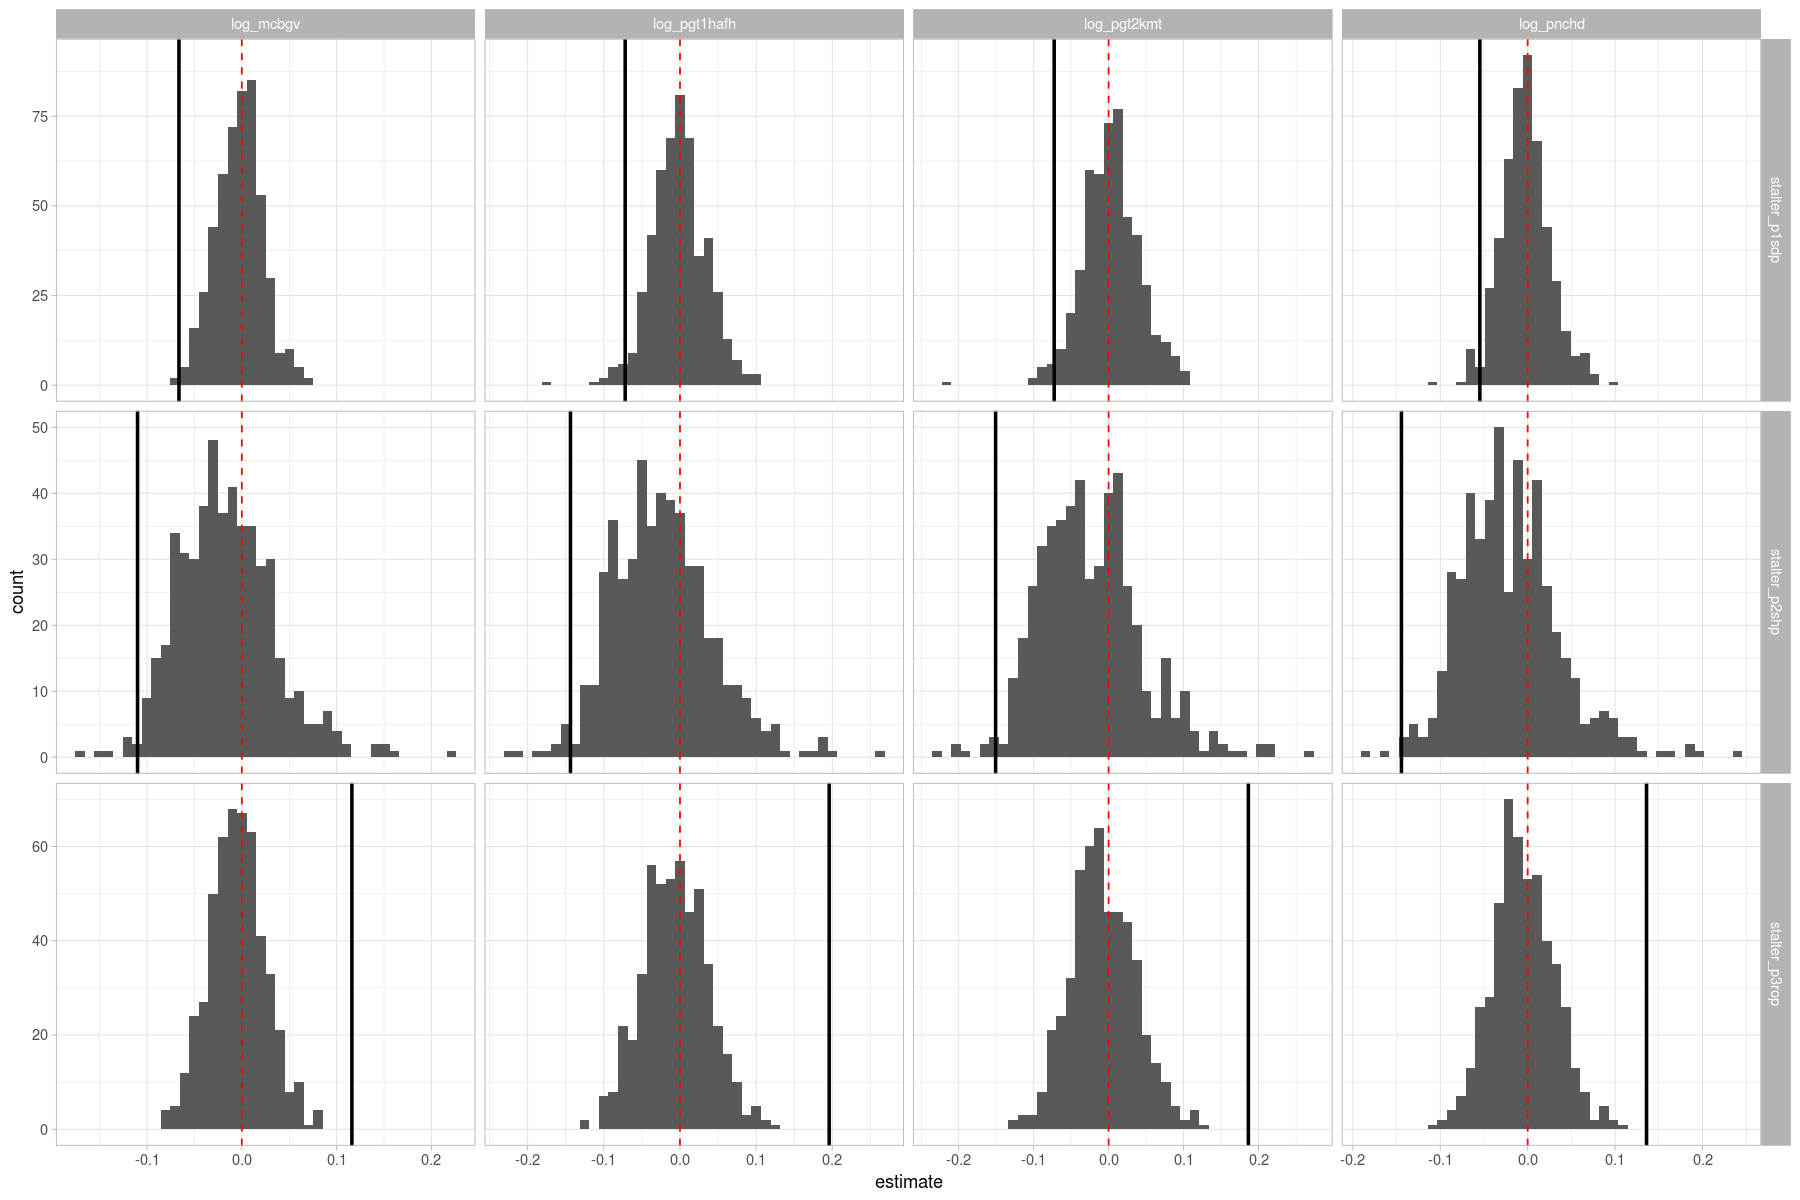

In [53]:
coefs %>%
    filter(!str_detect(var, 'new')) %>%
    filter(str_detect(var, 'stalter')) -> stalter_coefs

fri_results %>%
    filter(!str_detect(var, 'new')) %>%
    filter(str_detect(var, 'stalter')) %>%
    ggplot(aes(x = estimate)) +
    geom_histogram(bins = 40) +
    geom_vline(aes(xintercept = 0), size = 0.5, color = 'red', linetype = 2) +
    geom_vline(aes(xintercept = estimate), size = 1, data = stalter_coefs) + 
    facet_grid(var ~ dv, scales = 'free') +
    theme_light()